-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : /home/maichi/work/my_projects/CercareStatAnalysis/data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "CTH MAX"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: CTH MAX_lésion, CTH MAX_control, CTH MAX_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

#### 3.1 Check for missing values

Fully usable rows in train: 179/182 (98.4%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
CTH MAX_lésion,1.6,0.0
CTH MAX_control,0.5,0.0
CTH MAX_ratio,1.6,0.0


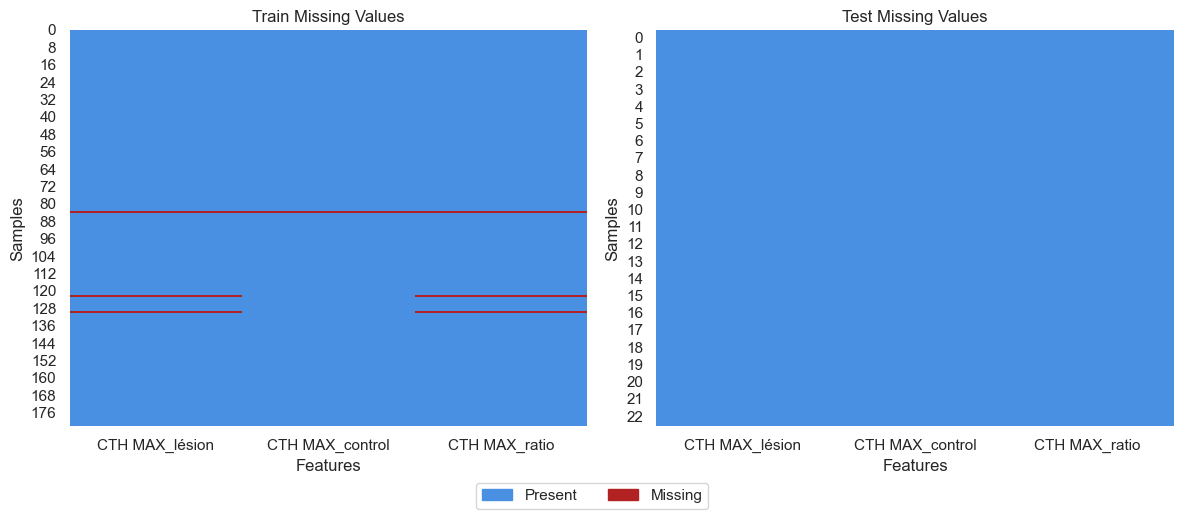

In [6]:
ub.check_missing_data()


#### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH MAX_lésion,179.0,5.188380,4.485028,0.10,1.945,3.75,7.555,24.12
CTH MAX_control,181.0,5.665967,3.965074,0.37,2.960,4.53,7.470,23.01



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CTH MAX_lésion,0,108.0,2.640833,1.636433,0.10,1.3900,2.32,3.4625,10.00
2,CTH MAX_lésion,1,71.0,9.063521,4.670442,2.62,5.6000,8.71,10.5500,24.12
1,CTH MAX_control,0,110.0,7.087091,4.245708,1.49,3.7575,6.36,9.0450,23.01
3,CTH MAX_control,1,71.0,3.464225,2.065876,0.37,2.1000,3.28,4.3600,14.58


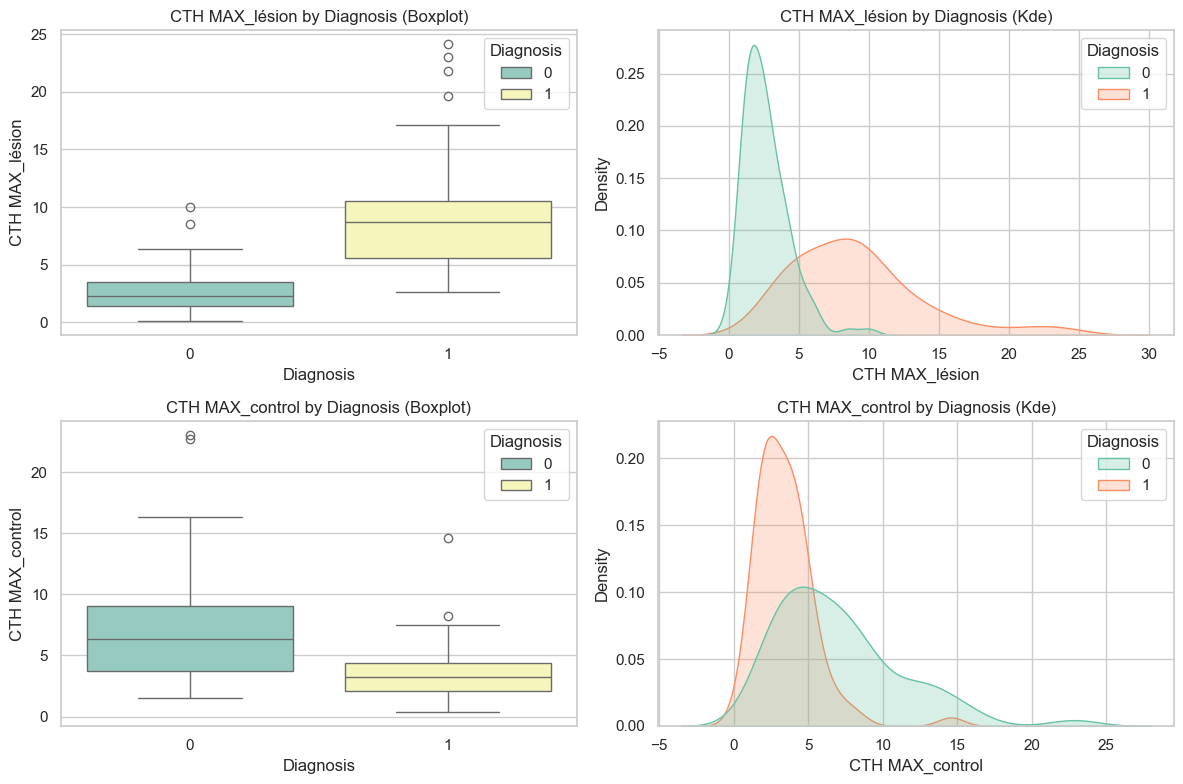

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

### 🔍 What we check

1. **Pearson correlation** (linear relationship)
2. **Spearman correlation** (monotonic relationship)
3. **Statistical significance** (p-values)

---


### ✅ How to interpret the results

| Correlation Outcome | Interpretation | Implication for Ratio |
|---------------------|----------------|------------------------|
| **Low Pearson + p > 0.05** | No linear relationship | ✅ Ratio may reveal important contrast |
| **High Pearson (r > 0.95) + p < 0.05** | Strong linear dependency | ❌ Ratio likely redundant |
| **Low Spearman + p > 0.05** | No monotonic trend | ✅ Ratio adds new information |
| **High Spearman (r > 0.9) + p < 0.05** | Strong non-linear alignment | ⚠️ Ratio may still help, but be cautious |
| **Moderate correlation with p < 0.05** | Weak but significant trend | ✅ Ratio is worth exploring further |

---

In summary:
> **We want Path and Control to be weakly or non-significantly correlated** — this increases the chance that the ratio introduces **new contrast** that is not already captured by absolute values.



🔍 Analyzing Biomarker: CTH MAX
-- Step 1: Correlation Analysis between Path and Control ----------------------
- Pearson  correlation: r = 0.056, p = 0.4576
- Spearman correlation: r = 0.085, p = 0.2553

-- Step 2: Summary Statistics for Ratio -----------------------------------------
Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH MAX_ratio,179.0,1.362994,1.385922,0.067114,0.365582,0.489387,2.311616,7.351351



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,NaN,0,108.0,0.389373,0.109550,0.067114,0.316516,0.387845,0.471808,0.676213
1,NaN,1,71.0,2.843995,1.085676,1.463415,2.101866,2.476395,3.078815,7.351351


-- Step 3: Visualize Relationships ---------------------------------------------


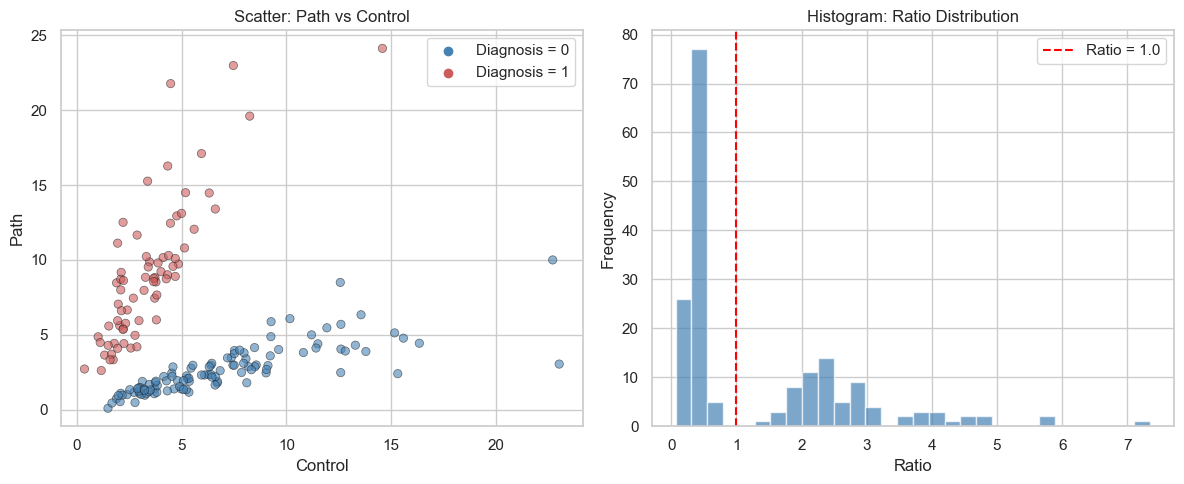

-- Step 4: Ratio Distributions by Diagnosis ----------------------------------------


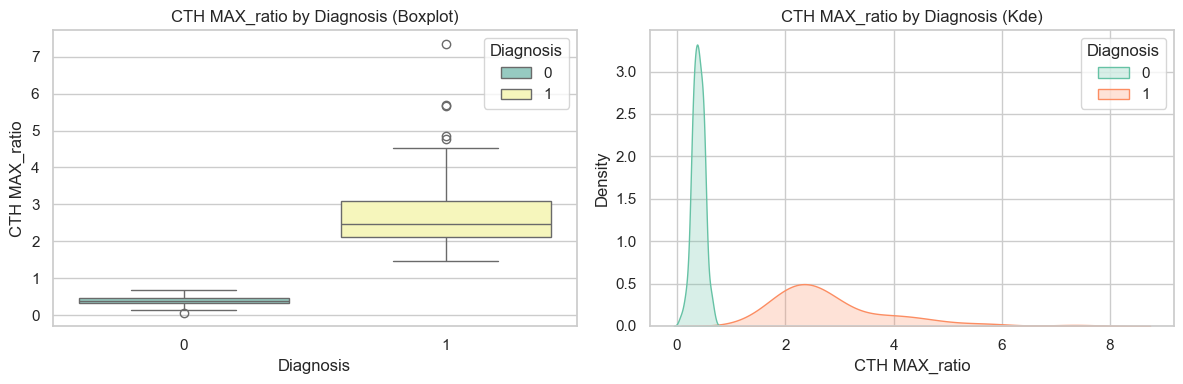

-- Step 5: Interpretation Guidance -----------------------------------------------
Pearson correlation is not statistically significant (p > 0.05) ! 


In [10]:
ub.analyze_path_control_ratio()
